In [2]:
import numpy as np
import pandas as pd
import timeit
from statistics import mean

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import seaborn as sns

In [3]:
def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.4f}%')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Coefficient of Determination: {r2:.4f}')

In [4]:
def fit_regressor(regressor, x_tr, y_tr, **kwargs):
    regressor.fit(x_tr, y_tr, **kwargs)

def predict_regressor(regressor, x_te):
    return regressor.predict(x_te)

In [5]:
df = pd.read_csv('avocado.csv', index_col=0)

In [6]:
 # split dataset into x and y
X = df.drop(columns='AveragePrice')
y = df['AveragePrice']

# encode non-numerical values
lbl = LabelEncoder()
X['type'] = lbl.fit_transform(X['type'].astype(str))
X['Date'] = lbl.fit_transform(X['Date'].astype(str))
X['region'] = lbl.fit_transform(X['region'].astype(str))

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
#XGBoost
xgbr = xgb.XGBRegressor(seed=42)

In [8]:
time = timeit.repeat(lambda: fit_regressor(xgbr, x_tr=X_train, y_tr=y_train), repeat=10, number=1)
print(f"Average fitting time: {mean(time):0.6f} seconds")

time2 = timeit.repeat(lambda: predict_regressor(xgbr, x_te=X_test), repeat=10, number=1)
print(f"Average prediction time: {mean(time2):0.6f} seconds")

Average fitting time: 0.790372 seconds
Average prediction time: 0.003327 seconds


In [9]:
y_hat = xgbr.predict(X_test)
regression_report(y_test, y_hat)

Mean Absolute Error: 0.0862
Mean Absolute Percentage Error: 6.2931%
Mean Squared Error: 0.0141
Root Mean Squared Error: 0.1186
Coefficient of Determination: 0.9124


In [10]:
node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': 'blue'}
leaf_params= {'shape': 'box',
              'style': 'filled',
              'fillcolor': 'red'}

fig = xgb.to_graphviz(xgbr, num_trees=0, condition_node_params=node_params,
                leaf_node_params=leaf_params)
fig.view(filename='../images/XGBoost_CatBoost_LightGBM/avocado_xgboost_simple_dtree')

'../images/XGBoost_CatBoost_LightGBM/avocado_xgboost_simple_dtree.pdf'

<AxesSubplot: xlabel='importance', ylabel='feature'>

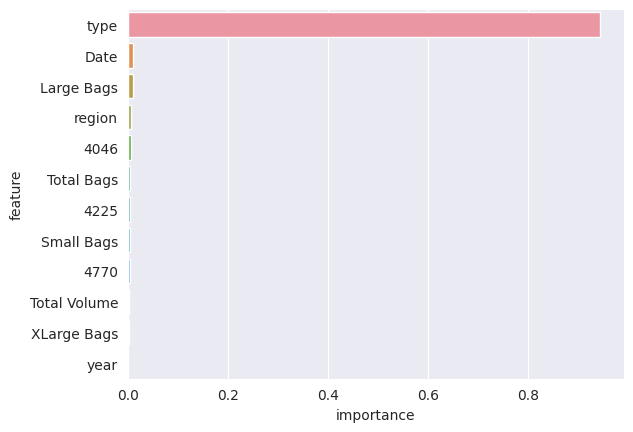

In [11]:
feature_importance = pd.DataFrame(xgbr.feature_importances_, xgbr.get_booster().feature_names).reset_index()
feature_importance.columns = ['feature', 'importance']
feature_importance.sort_values("importance", ascending=False, inplace=True)
sns.barplot(x='importance', y='feature', data=feature_importance)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


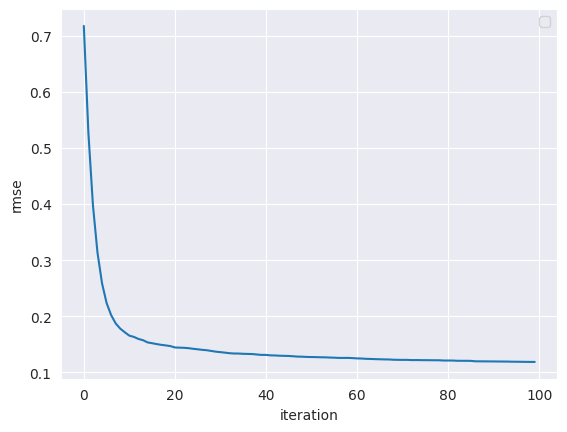

In [12]:
xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Extract the training and test loss values
test_loss = xgbr.evals_result_["validation_0"]["rmse"]

# Plot the training and test loss
plt.plot(test_loss)
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [13]:
bst = xgbr.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s:' % importance_type, bst.get_score(importance_type=importance_type))

weight: {'Date': 996.0, 'Total Volume': 676.0, '4046': 664.0, '4225': 688.0, '4770': 379.0, 'Total Bags': 437.0, 'Small Bags': 391.0, 'Large Bags': 443.0, 'XLarge Bags': 117.0, 'type': 23.0, 'region': 463.0}
gain: {'Date': 0.8288151025772095, 'Total Volume': 0.17945177853107452, '4046': 0.5076341032981873, '4225': 0.4161628782749176, '4770': 0.32052937150001526, 'Total Bags': 0.42896994948387146, 'Small Bags': 0.3524826765060425, 'Large Bags': 0.7680593729019165, 'XLarge Bags': 0.16111299395561218, 'type': 76.5654296875, 'region': 0.5625930428504944}
cover: {'Date': 1541.08740234375, 'Total Volume': 1526.4925537109375, '4046': 1284.4669189453125, '4225': 1444.31103515625, '4770': 1362.577880859375, 'Total Bags': 1959.64306640625, 'Small Bags': 1596.6597900390625, 'Large Bags': 1442.8330078125, 'XLarge Bags': 851.1709594726562, 'type': 5619.04345703125, 'region': 3193.4189453125}
total_gain: {'Date': 825.4998168945312, 'Total Volume': 121.30940246582031, '4046': 337.0690612792969, '4225

In [14]:
X_1 = X[['type', 'Date', 'Large Bags']]
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.20, random_state=42)

In [15]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5],
    'colsample_bytree':[ 0.3, 0.4]
}

In [16]:
3*3*3*3*3*2

486

In [17]:
np.power(3*3*3*3*3*2, 1/2)

22.045407685048602

In [18]:
rand_params = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(seed=42, subsample=0.8, n_estimators=40),
    cv=3, n_jobs=22, param_distributions=param_grid
)

In [19]:
%%time
rand_params.fit(X_train, y_train)
rand_params.best_params_

CPU times: user 1.64 s, sys: 147 ms, total: 1.78 s
Wall time: 3.43 s


{'scale_pos_weight': 5,
 'reg_lambda': 0,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.4}

In [20]:
param_grid2 = {
    'max_depth': [7, 9, 14],
    'learning_rate': [0.1, 0.2, 0.5],
    'gamma': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'scale_pos_weight': [1, 2],
    'colsample_bytree':[0.4, 0.6, 0.8]
}

In [21]:
3*3*2*2*2*3

216

In [22]:
np.power(3*3*2*2*2*3, 1/2)

14.696938456699069

In [23]:
rand_params = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(seed=42, subsample=0.8, n_estimators=40),
    cv=3, n_jobs=15, param_distributions=param_grid2
)

In [24]:
%%time
rand_params.fit(X_train, y_train)
rand_params.best_params_

CPU times: user 1.61 s, sys: 32.4 ms, total: 1.64 s
Wall time: 2.18 s


{'scale_pos_weight': 2,
 'reg_lambda': 0.1,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.8}

In [25]:
param_grid3 = {
    'max_depth': [7],
    'learning_rate': [0.5, 0.6, 0.7],
    'gamma': [0.1, 0.3],
    'reg_lambda': [0],
    'scale_pos_weight': [1],
    'colsample_bytree':[0.7, 0.8, 0.9]
}

In [26]:
opt_params = GridSearchCV(
    estimator=xgb.XGBRegressor(seed=42, subsample=0.8, n_estimators=40),
    cv=3, param_grid=param_grid3
)

In [27]:
%%time
opt_params.fit(X_train, y_train)
opt_params.best_params_

CPU times: user 1min 12s, sys: 464 ms, total: 1min 12s
Wall time: 10.1 s


{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.5,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1}

In [28]:
%%time
y_hat = opt_params.best_estimator_.predict(X_test)
regression_report(y_test, y_hat)

Mean Absolute Error: 0.1959
Mean Absolute Percentage Error: 14.6089%
Mean Squared Error: 0.0665
Root Mean Squared Error: 0.2578
Coefficient of Determination: 0.5862
CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 4.46 ms


<AxesSubplot: xlabel='importance', ylabel='feature'>

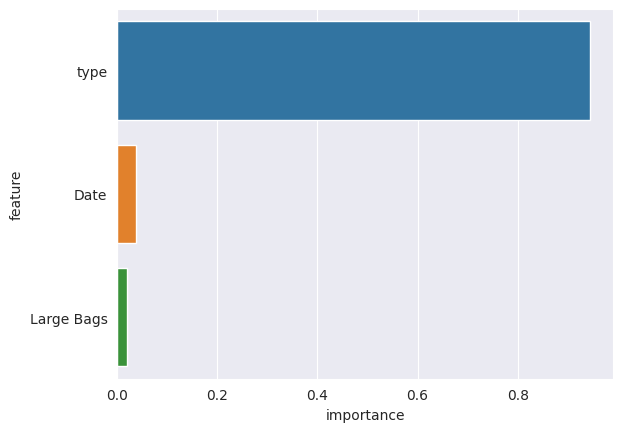

In [29]:
feature_importance = pd.DataFrame(opt_params.best_estimator_.feature_importances_, opt_params.best_estimator_.get_booster().feature_names).reset_index()
feature_importance.columns = ['feature', 'importance']
feature_importance.sort_values("importance", ascending=False, inplace=True)
sns.barplot(x='importance', y='feature', data=feature_importance)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


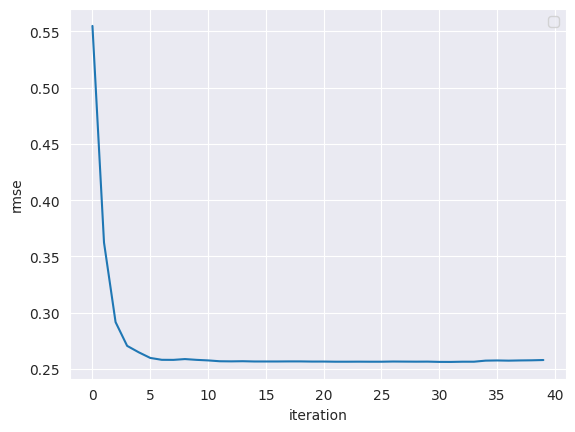

In [30]:
opt_params.best_estimator_.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Extract the training and test loss values
test_loss = opt_params.best_estimator_.evals_result_["validation_0"]["rmse"]

# Plot the training and test loss
plt.plot(test_loss)
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.legend()
plt.show()